In [57]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde

In [58]:
# check if the gpu is available or not, if yes, use gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [59]:
# set up the tuple for data, 
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])

In [60]:
args = {
    "train_iters": 1000,
    "pause_iters": 50,
    "hide_ticks": False,
    "save_ckpt":True,
    "likelihood":"laplace",
    "scale": 0.001,
    "adjoint": True,
    "debug": True,
    "seed": 42,
    'data':'segmented_cosine',
    "dt": 1e-2,
    "batch_size": 256,
    "method": 'euler',
    "adaptive": 'False',
    "rtol": 1e-3,
    "atol": 1e-3
    
}

In [61]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [62]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=0
        self._gamma = gamma
    def step(self, x:Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [63]:
# set the seed
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [64]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon)*b.sign())
    return a/b

In [65]:
class LatentSDE(torchsde.SDEIto): # sde with ito calculus
    def __init__(self, theta=1.0, mu=0.0, sigma=1):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2/(2.*theta))
        
        # prior drift
        #self.register_buffer("theta",torch.tensor([[theta]])) # prior parameters, register 成buffer, 参数不会进行更新
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma",torch.tensor([[sigma]]))
        
        # p(y0)
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))
        
        # approximate posterior drift: Takes in 2 positional encodings and the state
        self.net = nn.Sequential(
            nn.Linear(3,200),
            nn.Tanh(),
            nn.Linear(200,200),
            nn.Tanh(),
            nn.Linear(200,1)
        )
        
        
        
        # Initialization the parameters
        self.net[-1].weight.data.fill_(0.) # 初始化最后一层的参数
        self.net[-1].bias.data.fill_(0.)
            
        # q(y0)
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True) # 创建parameters
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True) # 创建parameters
        self.theta = nn.Parameter(torch.tensor([[theta]]),requires_grad=True)
        #self.theta = nn.Parameter(torch.tensor([[theta]]),requires_grad=True)
            
    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            t = torch.full_like(y, fill_value=t) # create a tensor of t
        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))

    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1) # 重复复制, 创建一个size为[y.size[0],1]

    def h(self, t, y):  # Prior drift.
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1] # 提取第一列，保持列的形态
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g) # 计算u(z,t)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True) # 计算integral
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std # the latent variable
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std) # approximate posterior distribution
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std) # prior distribution
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0). calculate the kl divergence
        #print(y0.size()) # (256, 1)
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1) # create the augmented initial value
        #print(aug_y0.size()) # [256, 2]
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args['method'],
            dt=args['dt'],
            adaptive=args['adaptive'],
            rtol=args['rtol'],
            atol=args['atol'],
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        ) # call the sde solver to 
        # print(aug_ys.size()) # [22, 256, 2]
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1] # get the integral of the u(z,t) at the last time
        
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        return sdeint_fn(self, y0, ts, bm=bm, method=args['method'], dt=args['dt'], names={'drift': 'h'}) # prior sde

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        return sdeint_fn(self, y0, ts, bm=bm, method=args['method'], dt=args['dt']) # posterior sde

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)


## 5. Simulation of time series

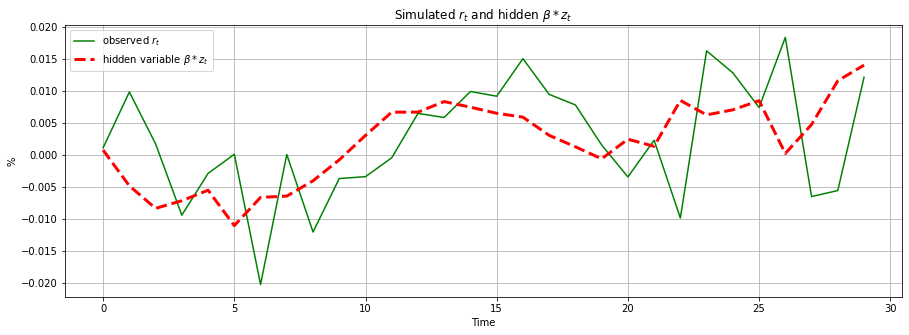

In [66]:
T = 30
#beta = 0.1694
beta=1
def make_time_series():
    
    
    phi = 0.9805
    sigma_v = 0.003342
    sigma_u = 0.00528
    rho = -0.856
    cov_uv = rho * sigma_u * sigma_v

    # generating shocks
    mu = [0,0]
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    shocks = np.random.multivariate_normal(mu, cov, T)

    z0 = np.random.normal(0, sigma_u**2/(1-phi**2),1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0

    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1][1]
        r[idx_t+1] = beta*z[idx_t] + shocks[idx_t+1][0]
    return z, r
z, r = make_time_series()
plt.figure(figsize=(15,5))
xvalues = np.array(range(T))
plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
plt.plot(xvalues, z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('%')
plt.grid(True)
plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
plt.show()

In [67]:
def make_data():
    ts_ = np.linspace(0.1,3.0,30)
    ts_ext_ = np.array([0.] + list(ts_) + [3.1])
    ts_vis_ = np.linspace(0.1, 3.1, 31)
    ys_ = r[:,None]
    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)  

In [68]:
def main():
    # Dataset
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
    mu = torch.mean(ys)
    sigma = torch.std(ys)
    
    # plotting parameters
    vis_batch_size = 1024
    ylims = (-0.02, 0.02)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
    
    eps = torch.randn(vis_batch_size, 1).to(device)
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size,1),
        device=device,
        levy_area_approximation="space-time")
    
    # Model
    model = LatentSDE(theta=0.01,mu=mu,sigma=sigma).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    kl_scheduler = LinearScheduler(iters=100)
    criterion = nn.BCELoss(reduction='sum')
    
    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()
    
    
    # show prior
    
    with torch.no_grad():
        zs = model.sample_p(ts=ts_vis, batch_size = vis_batch_size, eps = eps, bm=bm).squeeze()
       
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        #plt.scatter(ts_vis_, ys_, color='r', label="prior")
        zs_ = np.sort(zs_,axis=1)
        img_dir = os.path.join('./sim/','prior.png')
        plt.subplot(frameon=False)
        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_ = zs_[:, idx]
            zs_top_ = zs_[:, -idx]
            plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

        # `zorder` determines who's on top; the larger the more at the top.
        
        plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
        plt.plot(ts_, ys_, marker='x', zorder=3, color='k',label="observed $r_t$")
        plt.plot(ts_, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
        plt.ylim(ylims)
        plt.xlabel('$t$')
        plt.ylabel('$Y_t$')
        
        plt.tight_layout()
        plt.legend()
        plt.savefig(img_dir, dpi=300)
        plt.close()
        logging.info(f'Saved prior figure at: {img_dir}')
    
    
    for global_step in tqdm.tqdm(range(args['train_iters'])):
        
        # Plot and save.
        if global_step % args['pause_iters'] == 0:
            img_path = os.path.join("./sim/", f'global_step_{global_step}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if True: # args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if True: #args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if True: #args.show_samples:
                    #for j in range(num_samples):
                    #    plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)
                    plt.plot(ts_, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
                    plt.plot(ts_vis_, samples_.mean(axis=1), color='r',label=r'mean of latent variables')

                if True: #args.show_arrows:
                    num, dt = 3, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0, 3, num).to(device), torch.linspace(-0.3, 0.3, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if False: #args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.plot(ts_, ys_, marker='x', zorder=3, color='k', label="observed $r_t$ ") # new added
            

                
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.legend()
                plt.savefig(img_path, dpi=300)
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                
        
        # Train.
        optimizer.zero_grad() # zero the gradient
        zs, kl = model(ts=ts_ext, batch_size=args['batch_size']) # pass through the model, ys, logqp
        zs = zs.squeeze() # remove the dimensions of input of size 1
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args['likelihood']]
        likelihood = likelihood_constructor(loc=zs, scale=args['scale']) # create the laplace distribution
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0) # got the log likelihood

        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )
    torch.save(
        {'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'kl_scheduler': kl_scheduler},
        os.path.join('./sim/', f'global_step_{global_step}.ckpt')
    )


In [69]:
manual_seed(args['seed'])

if args['debug']:
    logging.getLogger().setLevel(logging.INFO)

ckpt_dir = os.path.join('./sim/', 'ckpts')
os.makedirs(ckpt_dir, exist_ok=True)

sdeint_fn = torchsde.sdeint_adjoint if args['adjoint'] else torchsde.sdeint

main()

INFO:root:Saved prior figure at: ./sim/prior.png
  0%|          | 0/1000 [00:00<?, ?it/s]INFO:root:Saved figure at: ./sim/global_step_0.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 0, logpy: -13.885, kl: 0.000, loss: 13.885
  5%|▌         | 50/1000 [01:49<34:14,  2.16s/it]INFO:root:Saved figure at: ./sim/global_step_50.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings

 10%|█         | 100/1000 [03:42<32:50,  2.19s/it]INFO:root:Saved figure at: ./sim/global_step_100.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 100, logpy: -613.832, kl: 223.245, loss: 684.166
 12%|█▏        | 123/1000 [04:34<32:22,  2.21s/it]INFO:root:global_step: 123, logpy: -486.241, kl: 197.392, loss: 562.281


 15%|█▌        | 150/1000 [05:36<32:24,  2.29s/it]INFO:root:Saved figure at: ./sim/global_step_150.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 150, logpy: -370.636, kl: 167.453, loss: 445.576
 19%|█▊        | 187/1000 [07:03<32:06,  2.37s/it]INFO:root:global_step: 187, logpy: -256.271, kl: 132.433, loss: 324.922


 20%|██        | 200/1000 [07:38<33:32,  2.52s/it]INFO:root:Saved figure at: ./sim/global_step_200.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 200, logpy: -225.305, kl: 122.157, loss: 291.491
 25%|██▌       | 250/1000 [09:45<29:53,  2.39s/it]INFO:root:Saved figure at: ./sim/global_step_250.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is

INFO:root:global_step: 250, logpy: -137.434, kl: 91.325, loss: 194.896
 30%|███       | 300/1000 [11:46<27:37,  2.37s/it]INFO:root:Saved figure at: ./sim/global_step_300.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 300, logpy: -85.950, kl: 70.924, loss: 136.387
 31%|███▏      | 314/1000 [12:21<27:42,  2.42s/it]INFO:root:global_step: 314, logpy: -76.848, kl: 66.574, loss: 125.624


 35%|███▌      | 350/1000 [13:48<25:59,  2.40s/it]INFO:root:Saved figure at: ./sim/global_step_350.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 350, logpy: -53.680, kl: 57.534, loss: 98.820
 38%|███▊      | 379/1000 [14:59<25:45,  2.49s/it]INFO:root:global_step: 379, logpy: -39.517, kl: 51.813, loss: 82.069


 40%|████      | 400/1000 [15:50<23:50,  2.38s/it]INFO:root:Saved figure at: ./sim/global_step_400.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 400, logpy: -30.931, kl: 48.529, loss: 71.961
 44%|████▍     | 444/1000 [17:39<22:21,  2.41s/it]INFO:root:global_step: 444, logpy: -18.750, kl: 42.864, loss: 56.795


 45%|████▌     | 450/1000 [17:54<22:30,  2.45s/it]INFO:root:Saved figure at: ./sim/global_step_450.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 450, logpy: -17.500, kl: 42.251, loss: 55.214
 50%|█████     | 500/1000 [19:57<20:13,  2.43s/it]INFO:root:Saved figure at: ./sim/global_step_500.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is no

 55%|█████▌    | 550/1000 [22:01<18:24,  2.45s/it]INFO:root:Saved figure at: ./sim/global_step_550.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 550, logpy: -0.568, kl: 34.643, loss: 33.551
 57%|█████▋    | 572/1000 [22:57<17:41,  2.48s/it]INFO:root:global_step: 572, logpy: 2.060, kl: 33.460, loss: 30.069


 60%|██████    | 600/1000 [24:07<16:36,  2.49s/it]INFO:root:Saved figure at: ./sim/global_step_600.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 600, logpy: 4.910, kl: 32.321, loss: 26.407
 64%|██████▍   | 638/1000 [25:48<16:08,  2.67s/it]INFO:root:global_step: 638, logpy: 7.578, kl: 30.845, loss: 22.581


 65%|██████▌   | 650/1000 [26:20<15:15,  2.62s/it]INFO:root:Saved figure at: ./sim/global_step_650.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 650, logpy: 8.412, kl: 30.480, loss: 21.460
 70%|███████   | 700/1000 [28:32<13:17,  2.66s/it]INFO:root:Saved figure at: ./sim/global_step_700.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not 

 75%|███████▌  | 750/1000 [30:45<10:37,  2.55s/it]INFO:root:Saved figure at: ./sim/global_step_750.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 750, logpy: 14.139, kl: 27.743, loss: 13.381
 77%|███████▋  | 766/1000 [31:26<09:40,  2.48s/it]INFO:root:global_step: 766, logpy: 14.787, kl: 27.405, loss: 12.428


 80%|████████  | 800/1000 [32:51<08:22,  2.51s/it]INFO:root:Saved figure at: ./sim/global_step_800.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 800, logpy: 15.964, kl: 26.757, loss: 10.659
 83%|████████▎ | 832/1000 [34:21<07:03,  2.52s/it]INFO:root:global_step: 832, logpy: 17.224, kl: 26.244, loss: 8.923


 85%|████████▌ | 850/1000 [35:06<06:17,  2.51s/it]INFO:root:Saved figure at: ./sim/global_step_850.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 850, logpy: 18.020, kl: 25.913, loss: 7.812
 90%|████████▉ | 898/1000 [37:08<04:35,  2.70s/it]INFO:root:global_step: 898, logpy: 19.996, kl: 25.376, loss: 5.330


 90%|█████████ | 900/1000 [37:14<04:37,  2.78s/it]INFO:root:Saved figure at: ./sim/global_step_900.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not guaranteed to converge to the correct solution when using adaptive "
INFO:root:global_step: 900, logpy: 20.075, kl: 25.366, loss: 5.242
 95%|█████████▌| 950/1000 [39:20<02:03,  2.47s/it]INFO:root:Saved figure at: ./sim/global_step_950.png
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchsde/_core/sdeint.py:278: UserWarning: Numerical solution is not guaranteed to converge to the correct solution when using adaptive time-stepping with the Euler--Maruyama method with non-additive noise.
  warnings.warn(f"Numerical solution is not 

100%|██████████| 1000/1000 [41:29<00:00,  2.49s/it]
